In [6]:
import pandas as pd
from model_predictions import model_prediction_list
from datasets import dataset_list
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from scipy import stats


In [2]:
for mp in model_prediction_list:
    mp.load_model_predictions()
    mp.get_sgrnas()

for ds in dataset_list:
    ds.load_data()
    ds.get_sgrnas()

model_datasets = model_prediction_list + dataset_list

In [3]:

model_data_summaries = []
for data in model_datasets:
    summary = {}
    summary['name'] = data.name
    summary['data_type'] = data.classtype
    summary['n_sgRNAs'] = len(data.sgrnas)
    model_data_summaries.append(summary)

model_data_summary_df = pd.DataFrame(model_data_summaries)
model_data_summary_df.sort_values('n_sgRNAs')

,name,data_type,n_sgRNAs
10,Kim2019_test,dataset,536
7,Doench2014_human,dataset,995
13,Wang_2014,dataset,1022
4,Chari2015,dataset,1145
6,Doench2014_mouse,dataset,1168
8,Doench2016,dataset,2536
0,Rule Set 2,model,4379
5,DeWeirdt2020,dataset,4630
12,Shalem_2014,dataset,4766
11,Koike-Yusa2014,dataset,6689


In [4]:
dataset_overlaps = []
for ds1 in model_datasets:
    for ds2 in model_datasets:
        if ds1.name != ds2.name:
            dataset_overlap = {}
            dataset_overlap['name_1'] = ds1.name
            dataset_overlap['name_2'] = ds2.name
            common_sgrnas = (pd.Series(list(ds1.sgrnas))
                             .isin(list(ds2.sgrnas))
                             .sum())
            dataset_overlap['overlap'] = common_sgrnas
            dataset_overlaps.append(dataset_overlap)

dataset_overlap_df = pd.DataFrame(dataset_overlaps)
filtered_overlap = dataset_overlap_df[dataset_overlap_df['overlap'] > 0].reset_index(drop=True)
filtered_overlap = (filtered_overlap.merge(model_data_summary_df
                                           .rename({'name': 'name_1'}, axis=1),
                                           how='inner', on='name_1'))
filtered_overlap['fraction_overlap'] = filtered_overlap['overlap']/filtered_overlap['n_sgRNAs']

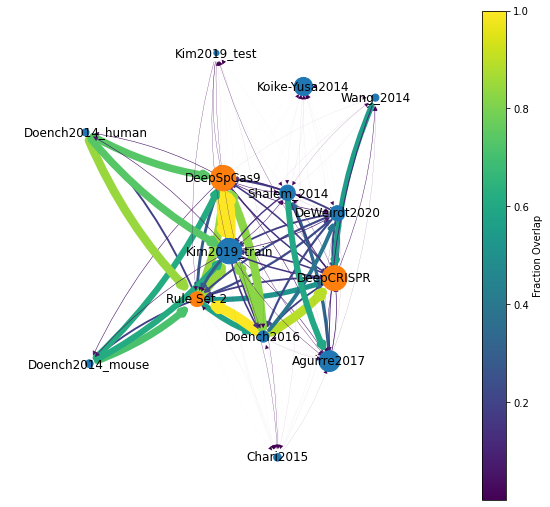

In [5]:
G = nx.from_pandas_edgelist(filtered_overlap, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (model_data_summary_df[['name', 'n_sgRNAs', 'data_type']]
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
plt.subplots(figsize=(10,9))
# layout
pos = nx.spring_layout(G, seed=7)
# edges
edge_width = [d['fraction_overlap']*10 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-|>", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap')
# nodes
node_size = [d['n_sgRNAs'] * 0.05 for _, d in G.nodes(data=True)]
node_color = ['tab:blue' if d['data_type'] == 'dataset' else 'tab:orange' for _, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
# labels
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.margins(x=0.2)

In [15]:
model_comparison_list = []
for i in range(len(model_prediction_list)):
    for j in range(i+1, len(model_prediction_list)):
        pred1 = model_prediction_list[i]
        pred2 = model_prediction_list[j]
        joined_predictions = pred1.prediction_df.merge(pred2.prediction_df, how='inner',
                                                       on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
        filtered_predictions = joined_predictions[~joined_predictions['sgRNA Sequence'].isin(pred1.sgrnas) &
                                                  ~joined_predictions['sgRNA Sequence'].isin(pred2.sgrnas)]
        for ds in dataset_list:
            ds_predictions = filtered_predictions.merge(ds.dataset, how='inner',
                                                        left_on=['sgRNA Sequence', 'sgRNA Context Sequence'],
                                                        right_on=[ds.sgrna_seq_col, ds.context_seq_col])
            if ds_predictions.shape[0] > 50:
                performance_dict = {}
                performance_dict['model1'] = pred1.name
                performance_dict['model2'] = pred2.name
                performance_dict['dataset'] = ds.name
                performance_dict['size'] = ds_predictions.shape[0]
                performance_dict['model1_spearman'] = stats.spearmanr(ds_predictions[pred1.prediction_col],
                                                                      ds_predictions[ds.rank_col])[0]
                performance_dict['model2_spearman'] = stats.spearmanr(ds_predictions[pred2.prediction_col],
                                                                      ds_predictions[ds.rank_col])[0]
                model_comparison_list.append(performance_dict)

performance_df = pd.DataFrame(model_comparison_list)
performance_df['difference'] = performance_df['model1_spearman'] - performance_df['model2_spearman']
performance_df

,model1,model2,dataset,size,model1_spearman,model2_spearman,difference
0,Rule Set 2,DeepSpCas9,Aguirre2017,8210,0.468766,0.511899,-0.043134
1,Rule Set 2,DeepSpCas9,Chari2015,1117,0.385993,0.445367,-0.059374
2,Rule Set 2,DeepSpCas9,DeWeirdt2020,3627,0.194005,0.228226,-0.034220
3,Rule Set 2,DeepSpCas9,Doench2014_mouse,329,0.309187,0.407365,-0.098178
4,Rule Set 2,DeepSpCas9,Doench2014_human,154,0.278753,0.291524,-0.012772
5,Rule Set 2,DeepSpCas9,Kim2019_test,522,0.581223,0.774453,-0.193230
6,Rule Set 2,DeepSpCas9,Koike-Yusa2014,6685,0.324754,0.355749,-0.030995
7,Rule Set 2,DeepSpCas9,Shalem_2014,4116,0.173094,0.213244,-0.040150
8,Rule Set 2,DeepSpCas9,Wang_2014,1018,0.465184,0.555781,-0.090597
9,Rule Set 2,DeepCRISPR,Aguirre2017,8057,0.470031,0.121068,0.348962


In [16]:
average_difference = (performance_df.groupby(['model1', 'model2'])
                      .apply(lambda df: ((df['model1_spearman'] - df['model2_spearman'])*df['size']).sum()/
                                        df['size'].sum())
                      .reset_index(name='avg_difference'))
average_difference


,model1,model2,avg_difference
0,DeepSpCas9,DeepCRISPR,0.282815
1,Rule Set 2,DeepCRISPR,0.285461
2,Rule Set 2,DeepSpCas9,-0.044394
